# Анализ воронки событий и результатов А/А/В-теста <a name="0"></a>

Исследование поводилось для магазина продуктов питания, пользователи которого делают заказы на дом через приложение.  
  
**Задачи проекта:** 
* изучить поведение пользователей,  
* выявить "узкие" места по воронке событий,  
* оценить результаты А/А/В-теста для нового шрифта в приложении,  
* дать рекомендации.  

____
### Оглавление

#### [Часть 1. Первичное изучение полученных данных](#1)

   [1.1 Загрузка библиотек и файлов с данными](#1.1)  
   [1.2 Изучение основных параметров датафрейма](#1.2)  
   [1.3 Выводы: описание полученных данных и основных проблем](#1.3)  
   
#### [Часть 2. Подготовка данных к анализу](#2)

   [2.1 Устранение проблем в данных](#2.1)  
   [2.2 Изучение содержания логов и качества данных](#2.2)  
   [2.3 Выводы](#2.3)  
   
#### [Часть 3. Анализ поведения пользователей через воронку событий](#3)

   [3.1 Сформулируем воронку событий](#3.1)  
   [3.2 Описание ключевых событий](#3.2)  
   [3.3 Визуализация воронки ключевых событий](#3.3)  
   [3.4 Выводы](#3.4)  
   
#### [Часть 4. Анализ результатов А/А/В-теста](#4)

   [4.1 Проверка статистической значимости результатов теста](#4.1)  
   [4.2 Выводы](#4.2)  
   
#### [Часть 5. Общие выводы и рекомендации](#5)

# Часть 1. Первичное изучение полученных данных <a name='1'></a>

### 1.1 Загрузка библиотек и файлов с данными <a name="1.1"></a>

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

# визуализация
import seaborn as sns
from plotly import graph_objects as go 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # для корректной работы с графиками matplotlib

# дефолтные параметры отображения графиков plotly
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2
pio.renderers.default = "svg"

# для работы с А/А/В-тестом
from scipy import stats as st
import math as mth

In [2]:
logs_data = pd.read_csv('datasets/9_logs_exp.csv', sep='\t')
logs_data.head(3)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


### 1.2 Изучение основных параметров датафрейма <a name="1.2"></a>

In [3]:
# функция для изучения ключевых параметров
def df_info(data):
    print('\033[1m\033[34mПервые строки таблицы:\033[0m')
    display(data.head(3))
    print('\033[1m\033[34mОбщая информация о данных в таблице:\033[0m')
    display(data.info())
    print('\033[1m\033[34mКоличество дубликатов:\033[0m {}'.format(data.duplicated().sum()))

In [4]:
df_info(logs_data)

Первые строки таблицы:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248


Общая информация о данных в таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Количество дубликатов: 413


In [5]:
# скорректируем названия столбцов
logs_data = logs_data.rename(columns={'EventName':'event_name',
                                      'DeviceIDHash':'user_id',
                                      'EventTimestamp':'event_datetime',
                                      'ExpId':'group_id'})

### 1.3 Выводы: описание полученных данных и основных проблем <a name='1.3'></a>

В датафрейме хранятся данные о логах в приложении для трех групп пользователей A/A/B-теста:  
* 246 и 247 — две контрольные группы (А1 и А2)  
* 248 — тестовая группа, которая видит приложение с новыми шрифтами (В)  
  
В таблице 4 колонки:  
* `event_name` содержит название события в приложении,  
* `user_id` — уникальный ID пользователя,  
* `event_datetime` — время, когда событие было совершено,  
* `group_id` идентификатор группы A/A/B-теста.  
Для удобства работы с данными первоначальные наименования столбцов были заменены.  
  
Пропуски в данных не обнаружены, есть необходимость заменить тип данных для колонки `event_timestamp` с int на datetime, а также удалить полные дубликаты — 413 штук строк.

# Часть 2. Подготовка данных к анализу <a name='2'></a>

### 2.1 Устранение проблем в данных <a name='2.1'></a>

In [6]:
# удалим дубликаты
logs_data = logs_data.drop_duplicates().reset_index(drop=True)

In [7]:
# корректировка типа данных о дате и времени
logs_data['event_datetime'] = logs_data['event_datetime'].map(lambda x: pd.Timestamp(x, unit='s'))
logs_data['event_date'] = pd.to_datetime(logs_data['event_datetime'].dt.date)

In [8]:
# проверим результат
logs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      243713 non-null  object        
 1   user_id         243713 non-null  int64         
 2   event_datetime  243713 non-null  datetime64[ns]
 3   group_id        243713 non-null  int64         
 4   event_date      243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


In [9]:
logs_data.head(3)

,event_name,user_id,event_datetime,group_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25


### 2.2 Изучение содержания логов и качества данных <a name='2.2'></a>

In [10]:
print('Количество событий: {}'.format(logs_data['event_name'].count()), 
      'Количество пользователей: {}'.format(logs_data['user_id'].nunique()), 
      'Кол-во событий на пользователя: среднее {:.1f} и медиана {:.1f}'.format(logs_data.groupby('user_id')
                                                                                        .agg({'event_name':'count'})
                                                                                        ['event_name']
                                                                                        .mean(), 
                                                                               logs_data.groupby('user_id')
                                                                                        .agg({'event_name':'count'})
                                                                                        ['event_name']
                                                                                        .median()),
      sep='\n')

Количество событий: 243713
Количество пользователей: 7551
Кол-во событий на пользователя: среднее 32.3 и медиана 20.0


In [11]:
print('Виды событий:', '{}'.format(logs_data['event_name'].unique()), sep='\n')

Виды событий:
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


In [12]:
print('В таблице хранятся данные за период с {} по {}'.format(logs_data['event_date'].min().date(), 
                                                              logs_data['event_date'].max().date()))

В таблице хранятся данные за период с 2019-07-25 по 2019-08-07


Text(0.5, 0, 'Дата события')

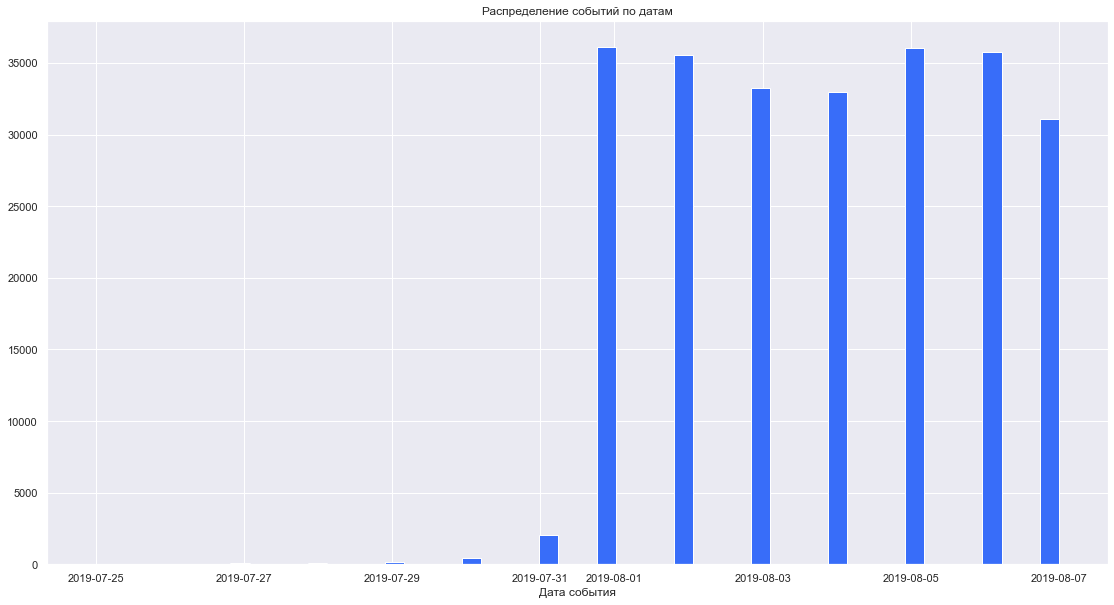

In [13]:
# основные настройки для отображения графиков
sns.set(rc={"figure.figsize":(19, 10)}, font_scale=1, style='darkgrid', palette='rainbow')

# построим гистограмму для событий для всего периода
logs_data['event_date'].hist(bins=50)
plt.title('Распределение событий по датам')
plt.xlabel('Дата события')

По гистограмме событий за весь период видно, что события распределены неравномерно и основная масса данных приходится на период с 1 по 7 августа 2019 года. Более ранние данные могут влиять на результаты, поэтому отбросим неполные данные о событиях, свершенных ранее 1 августа.

In [14]:
print('Кол-во событий до 31.07.2019 включительно: {}'.format(logs_data.query('event_date <= "2019-07-31"')
                                                             ['event_name']
                                                             .count()),
      'Кол-во пользователей, совершивших эти события: {}'.format(logs_data.query('event_date <= "2019-07-31"')
                                                                 ['user_id']
                                                                 .nunique()), 
      sep='\n')

Кол-во событий до 31.07.2019 включительно: 2826
Кол-во пользователей, совершивших эти события: 1451


In [15]:
# сохраним корректную информацию в новый датафрейм
correct_logs = logs_data.query('event_date > "2019-07-31"').reset_index(drop=True).copy()

In [16]:
# изучим кол-во пользователей в группах А/А/В-теста
correct_logs.groupby('group_id').agg({'user_id':'nunique'})

,user_id
group_id,
246,2484
247,2513
248,2537


### 2.3 Выводы <a name='2.3'></a>

В процессе изучения гистограммы было выявлено, что за период с 25 по 31 июля в датафрейме хранятся неполные данные о совершенных пользователями событий — это ~1,16% от общего количества событий для ~19% пользователей. Наиболее полные данные есть за период с 1 по 7 августа 2019, срез корректных данных хранится в таблице `correct_logs`.  
  
Все события разделены на 5 видов:  
* `MainScreenAppear` — просмотр главного экрана,  
* `PaymentScreenSuccessful` — покупка успешно совершена,  
* `CartScreenAppear` — переход в корзину,  
* `OffersScreenAppear` — появился экран предложния (карточка товара),  
* `Tutorial` — инструкции.  
  
В таблице представлены все три группы А/А/В-теста.

# Часть 3. Анализ поведения пользователей через воронку событий <a name='3'></a>

### 3.1 Сформулируем воронку событий

In [17]:
# отсортируем таблицу по частоте событий и числу пользователей
funnel = (correct_logs
          .groupby('event_name')
          .agg({'event_datetime':'count', 'user_id':'nunique'})
          .sort_values(by='user_id', ascending=False)
          .reset_index())

funnel.columns = ['event_name', 'event_cnt', 'user_cnt']

# доля пользователей, свершивших событие от общего числа уникальных пользователей
funnel['part_users_of_all'] = round(funnel['user_cnt'] / correct_logs['user_id'].nunique() * 100, 2)

funnel

,event_name,event_cnt,user_cnt,part_users_of_all
0,MainScreenAppear,117328,7419,98.47
1,OffersScreenAppear,46333,4593,60.96
2,CartScreenAppear,42303,3734,49.56
3,PaymentScreenSuccessful,33918,3539,46.97
4,Tutorial,1005,840,11.15


In [18]:
# дополнительно посмотрим, как ведут себя пользователи, которые хоть раз обращались к инструкции
tutorial_user = correct_logs.query('event_name == "Tutorial"')['user_id'].unique()
(correct_logs
 .query('user_id in @tutorial_user')
 .groupby('event_name')
 .agg({'user_id':'nunique', 'event_datetime':'count'})
 .sort_values(by='event_datetime', ascending=False)
)

,user_id,event_datetime
event_name,,
MainScreenAppear,836,11689
OffersScreenAppear,644,8030
CartScreenAppear,542,6658
PaymentScreenSuccessful,467,4301
Tutorial,840,1005


### 3.2 Описание ключевых событий<a name='3.2'></a>  
  
Если описывать путь пользователя по количеству событий и уникальных пользователей на каждом этапе, то можно предположить следующий вариант пути пользователя:  

Для большинства пользователей сессия начинается с захода на главный экран (MainScreenAppear), далее пользователь переходит к карточке товаров (OffersScreenAppear), потом следует в корзину (CartScreenAppear) для проверки заказа и оплаты, после успешной оплаты пользователь видит экран об успешной покупке (PaymentScreenSuccessful). Посещение раздела Tutorial не обязательно, его можно не учитывать в воронке.  
  
Так как OffersScreenAppear не имеет кратного увеличения по кол-ву заходов в сравнении с заходами в корзину (46333 просмотров предложения и 42303 переходов корзину), при этом здесь речь идет о приложении для покупки продуктов питания (предполагает много мелких товаров в одной корзине) — событие OffersScreenAppear не учитывает заход в каждую карточку товара, а отражает один переход в каталог для пользователя.  

***Воронка ключевых событий:***  
*главный экран (MainScreenAppear) — переход в каталог товаров (OffersScreenAppear) — переход в корзину (CartScreenAppear) — экран успешной покупки (PaymentScreenSuccessful)*  
  
Была гипотеза, что новые пользователи чаще начинают сессию с ознакомления с разделом Tutorial, однако, изучение данных по пользователям, которые хоть раз использовали Tutorial гипотезу не подтвердило. Наиболее вероятен сценарий, что новый пользователь заходит на главный экран и знакомится с сервисом самостоятельно. Раздел Tutorial вероятнее всего посещается либо сразу  после главного экрана, либо в случае возникновения проблем. Большая часть пользователей не заходила в этот раздел больше 1 раза.  

### 3.3 Визуализация воронки ключевых событий <a name='3.3'></a>  

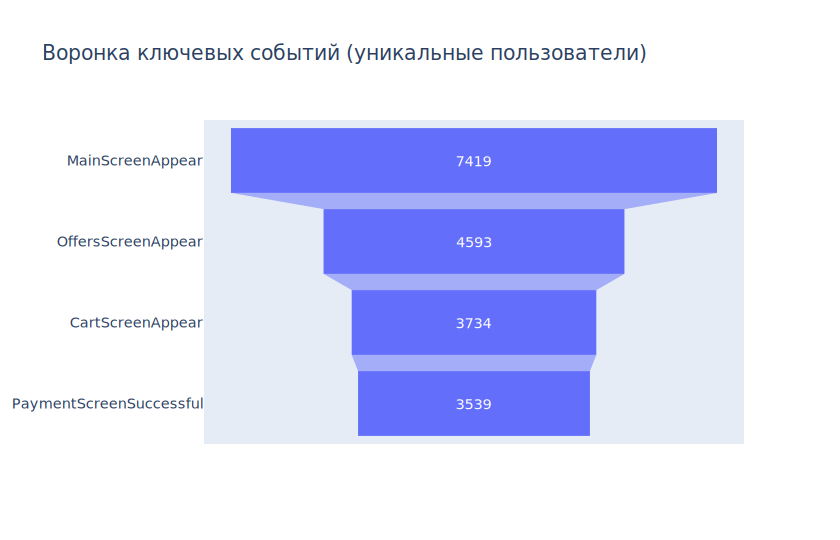

In [19]:
# визуализируем воронку событий
event_for_funnel = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
y_funnel = list(funnel.query('event_name in @event_for_funnel')['event_name'])
x_funnel = list(funnel.query('event_name in @event_for_funnel')['user_cnt'])

fig_funnel = go.Figure(go.Funnel(y=y_funnel, x=x_funnel,hoverinfo = "y+percent initial+percent previous"))
fig_funnel.update_layout(title='Воронка ключевых событий (уникальные пользователи)')
fig_funnel.show()

Всего 1.13% уникальных пользователей не посещали главный экран в период с 1 по 7 августа, это могло произойти в случае, если пользователи ранее положили товары в корзину и вернулись к ней позже по прямой ссылке. Так как процент таких пользователей мало и их количество не может существенно повлиять на результаты исследования, мы не учитывали этот сценарий при построении воронки и взяли количество посетителей главной страницы за 100%. 
  
**Основные наблюдения:**  
* 61.9% всех пользователей, посетивших главный экран, перешли в каталог товаров,  
* 50.3% от всех пользователей дошли до корзины — это 81% от тех, кто перешел в каталог товаров,  
* 47.7% от всех пользователей успешно оплатили покупки — это 94.8% от тех, кто перешел в корзину,  
* основные потери происходят на этапе перехода в каталог товаров,  
* также заметные потери есть на этапе перехода из каталога в корзину.  

### 3.4 Выводы <a name='3.4'></a>

Наибольшее количество пользователей **мы теряем на этапе переход от главного экрана к каталогу — 38.1%**.  

**Это может быть связано со следующими причинами:**  
— *первое знакомство* с сервисом, пока нет потребности в заказе, скачал приложение и изучил возможности (новый пользователь, ничего не положил в корзину, короткая сессия): мягко напомнить о приложении, например, дать скидку на первый заказ  
— *не разобрался и ушел*: обращать внимание на поведение пользователей, которые посетили главный экран, Tutorial и ушли из сервиса — если доля таких пользователей будет расти, то обратить внимание на удобство сервиса и какие изменения на главном экране произошли   

**На этапе перехода из каталога в корзину мы теряем 19% пользователей** (49.7% пользователей, посетивших главный экран не дошли до корзины).  

**Это может быть связано со следующими причинами:**  
— *нет ключевых товаров на сайте*, ради которых пользователь пришел: рекомендуем изучить поведение пользователей с "брошенными" корзинами и обратную связь, сравнить запросы в поисковой строке приложения с ассортиментом  
— *не устроили цены/условия доставки*: не можем напрямую влиять на цены, но можем оставаться конкурентноспособными, мониторя конкурентов и ценовую политику рынка продуктов питания  
— *проблемы с интерфейсом*: были ли изменения в интерфейсе каталога, которые могли повлиять на экспириенс пользователя, были ли изменения в CJM, как долго пользователи остаются в каталоге (есть ли паттерны и изменения)?

Так как у нас нет прототипа приложения и мы можем только предположить об опыте клиента по имеющимся логам, **мы можем предложить дополнительно несколько гипотез для дальнейшей работы:**  
1) Какова цель "главного экрана" приложения? Возможно, если вести сразу на каталог товаров, конверсия пользователей в покупателей вырастет,  
2) Как Tutorial влияет на поведение пользователей? Возможно, пользователи, которые столкнулись со сложностями и обратились к инструкциям, потом перешли к покупке в отличие от тех, кто этого не сделал.  
3) Какие сценарии поведения свойственны пользователям, воспользовавшимся подсказками? Возможно, если для новых пользователей ввести интерактивный сценарий подсказок в каталоге, процент переходов в корзину вырастет.

# Часть 4. Анализ результатов А/А/В-теста <a name='4'></a>

### 4.1 Проверка статистической значимости результатов теста <a name='4.1'></a>

In [20]:
# подготовим данные
# группы для сравнения
group_a_one = correct_logs.query('group_id == 246')[['event_name', 'user_id']].reset_index(drop=True)
group_a_two = correct_logs.query('group_id == 247')[['event_name', 'user_id']].reset_index(drop=True)
group_a_all = correct_logs.query('group_id != 248')[['event_name', 'user_id']].reset_index(drop=True)
group_b = correct_logs.query('group_id == 248')[['event_name', 'user_id']].reset_index(drop=True)

При проверки результатов теста мы будем работать с долями, поэтому необходимо применить методику проверки гипотез о равенстве долей. У нас есть три ключевых события для которых мы будем проводить тесты между группами А1 и А2, А1 и В, А2 и В, А1+А2 и В — это означает, что **необходимо ввести поправку на множественное сравнение**. Мы возьмем стандартное значение `alpha = 0.05` и воспользуемся простой поправкой Бонферрони, где уровень значимости делится на количество сравнений — в нашем случае для 4 групп и 4 события уровень значимости разделим на 16.

*Нулевая гипотеза:* после замены шрифтов поведение пользователей не изменилось.  
*Альтернативная гипотеза:* шрифты повлияли на поведение пользователей.

In [21]:
# критический уровень статистической значимости 
alpha = 0.05
test_correction = 16

# функция для статистической проверки гипотез
def z_test(group_one, group_two, event, bonferroni_correction):
    '''
    На входе функция получает данные о двух сравниваемых группах, 
    наименование шага воронки и значение поправки Бонферрони 
    (если нет множественности проверки, установить значение 1).
    На выходе — ответ о наличии или отсутствии статистической значимости
    между сравниваемыми группами. Тест двусторонний.
    '''
    # кол-во пользователей, совершивших событие в сравниваемых группах 1 и 2
    successes = np.array([group_one.query('event_name == @event')['user_id'].nunique(), 
                          group_two.query('event_name == @event')['user_id'].nunique()])
    
    # кол-во уникальных пользователей в сравниваемых группах 1 и 2
    trials = np.array([group_one['user_id'].nunique(), 
                       group_two['user_id'].nunique()])
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    
    # статистика в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    
    # для двустороннего теста
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    
    # зададим поправку на множественный тест
    bonferroni_alpha = alpha / test_correction

    if (p_value < bonferroni_alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [22]:
# сравним группы А1 и А2
print('\033[1m\033[34mГруппы А1 и А2\033[0m')
for event in event_for_funnel:
    print('Проверка для события \033[1m{}\033[0m'.format(event))
    z_test(group_a_one, group_a_two, event, test_correction)
    print()

Группы А1 и А2
Проверка для события MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Мы проверили две тестовые группы А1 и А2 и установили, что нет оснований считать доли разными, а значит — группы подходят для проведдения дальнейших сравнений с тестовой и мы можем считать, что на них не влияли сторонныие факторы, искажающие эксперимент.

In [23]:
# сравним группы А1 и В
print('\033[1m\033[34mГруппы А1 и В\033[0m')
for event in event_for_funnel:
    print('Проверка для события \033[1m{}\033[0m'.format(event))
    z_test(group_a_one, group_b, event, test_correction)
    print()

Группы А1 и В
Проверка для события MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [24]:
# сравним группы А2 и В
print('\033[1m\033[34mГруппы А2 и В\033[0m')
for event in event_for_funnel:
    print('Проверка для события \033[1m{}\033[0m'.format(event))
    z_test(group_a_two, group_b, event, test_correction)
    print()

Группы А2 и В
Проверка для события MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [25]:
# сравним группы A1+А2 и В
print('\033[1m\033[34mГруппы A1+А2 и В\033[0m')
for event in event_for_funnel:
    print('Проверка для события \033[1m{}\033[0m'.format(event))
    z_test(group_a_all, group_b, event, test_correction)
    print()

Группы A1+А2 и В
Проверка для события MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Проверка для события PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Во всех случаях мы не можем отвергнуть нулевую гипотезу и считать изменения статистически значимыми. Судя по результатам эксперимента мы не можем утверждать, что изменение шрифта в приложении влияет на конверсии в ключевые события.

### 4.2 Выводы <a name='4.2'></a>

Для проведения анализа результатов А/А/В-теста мы применили метод проверки гипотез о разнице долей с учетом множественности эксперимента (применили критерий Бонферрони). Мы провели сравнение тестовых групп, чтобы убедиться, что на ход эксперимента не влияли сторонние факторы, далее провели сравнения для тестовой группы.  
  
В результате А/А/В-теста мы не смогли отвергнуть нулевую гипотезу о равенстве долей, это означает, что мы не можем считать изменения статистически значимыми. **Мы не можем утверждать, что изменение шрифта повлияет на поведения пользователей в рамках отслеживаемой воронки событий.**

# Часть 5. Общие выводы и рекомендации <a name='5'></a>

**Для оценки поведения пользователей в приложении мы выделили в воронке событий ключевые:**  
— главный экран (MainScreenAppear)  
— переход в каталог товаров (OffersScreenAppear)  
— переход в корзину (CartScreenAppear)  
— экран успешной покупки (PaymentScreenSuccessful)  

**Основные потери пользователей** происходят на этапе перехода в каталог товаров (уходят до 38.1% пользователей, увидивших главный экран), а также заметные потери есть на этапе перехода из каталога в корзину (уходят до 19% пользователей, перешедших в каталог). 

Мы предложили несколько причин, по котором может снижаться конверсия на этих этапах, **рекомендуем первостепенно обратить внимание на следующие моменты:**
* были ли изменения на главном экране в последнее время, как они сказались на конверсии в сравнении за более ранние периоды (если были),  
* были ли изменения в приложении, которые могли повлиять на экспириенс пользователя, связанные с CJM,  
* понаблюдать за поведением новых пользователей в приложении (когда наступает wow-эффект) – понять причины ухода без посещения каталога (не разобрался с интерфейсом, приложение запрашивает регистрацию на главном экране, не ставил цели заказа - хотел посмотреть...): в зависимости от "находок" предложить новым пользователям бонус на первую покупки или другую стимулирующую акцию,  
* понаблюдать за поведением лояльных клиентов: что ищут в каталоге, как часто уходят, если не нашли нужного товара, как работает поиск по товарам в приложении.  

Конверсия в покупку для пользователей, перешедших из каталога в корзину высокая 94.8% — есть ли механики в приложении, которые предлагают пользователям, которые что-то не обнаружили в каталоге, перейти в корзину и приобрести оставшиеся товары? Есть ли система рекомендаций похожих товаров или возможность установить напоминание, когда товар появится, чтобы вернуть клиента к брошенной корзине?  

**Также предложена гипотеза для будущих исследований:**   
Какова цель "главного экрана" приложения? Возможно, если вести сразу на каталог товаров, конверсия пользователей в покупателей вырастет.  
  
___
Также мы провели анализ А/А/В-теста, в котором тестовая группа видела новые шрифты в приложении.  
**Результат:** мы не смогли отвергнуть нулевую гипотезу о равенстве долей, это означает, что мы не можем считать изменения статистически значимыми. Мы не можем утверждать, что изменение шрифта повлияет на поведения пользователей в рамках отслеживаемой воронки событий.